In [73]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
from scipy import ndimage
from matplotlib import pyplot
import scipy
from PIL import Image
from skimage import measure
import math

# import image

In [2]:
cd U:\Siyan\xupeng

U:\Siyan\xupeng


In [14]:
# load a single image to determine image size
f = Image.open("mask41noassign.vsseg_export_s100.png")
im = np.asarray(f)
im.shape

In [279]:
# z is section number
# n is the original segmentation image volume
z = 31
n = np.zeros((z,im.shape[0],im.shape[1]),dtype = 'uint8')

In [280]:
for i in range(z):
    f = Image.open("mask41noassign.vsseg_export_s" +str("%03d"%j)+".png")
    im = np.asarray(f)
    
    # if empty section, copy from the section above
    if np.sum(im) == 0:
        im = n[i-1]
        
    n[i] = im

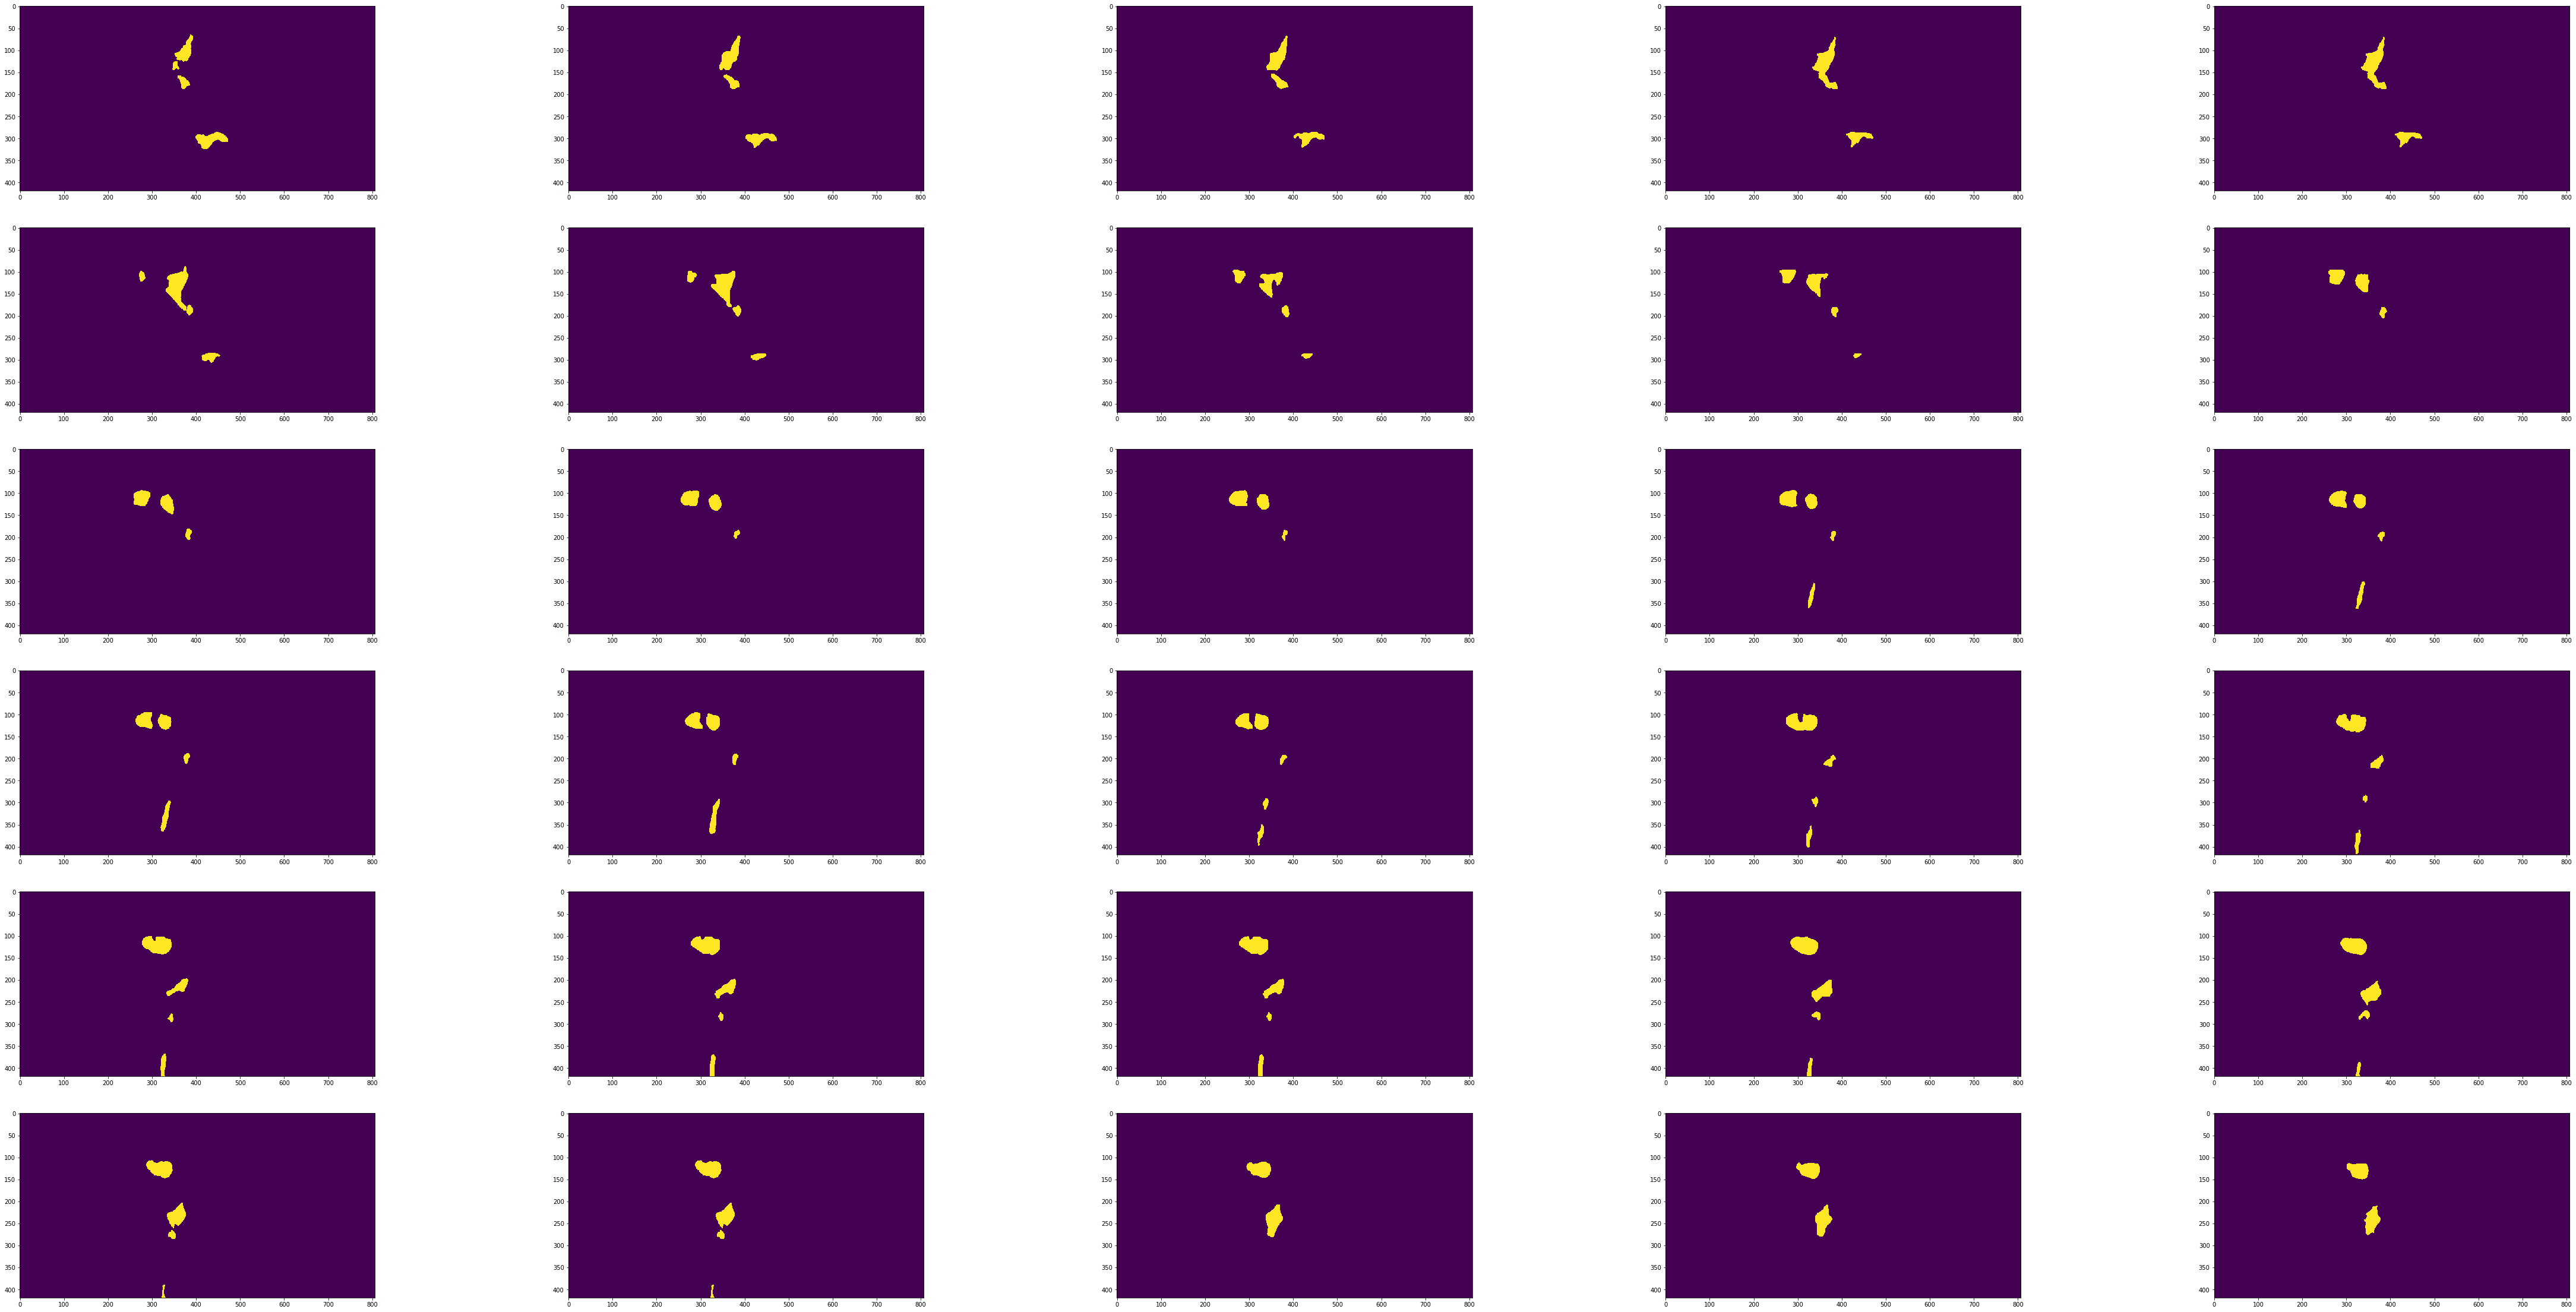

In [63]:
# visualization of the original segmentation image volume
fig,ax = plt.subplots(6,5,figsize = (80,40))
for i in range(6):
    for j in range(5):
        ax[i,j].imshow(n[5*i+j])

# smooth

### optical flow

In [34]:
flow = cv2.calcOpticalFlowFarneback(n[0],n[1],None , 0.5, 3, 15, 3, 5, 1.2, 0)

In [43]:
flow.dtype

dtype('float32')

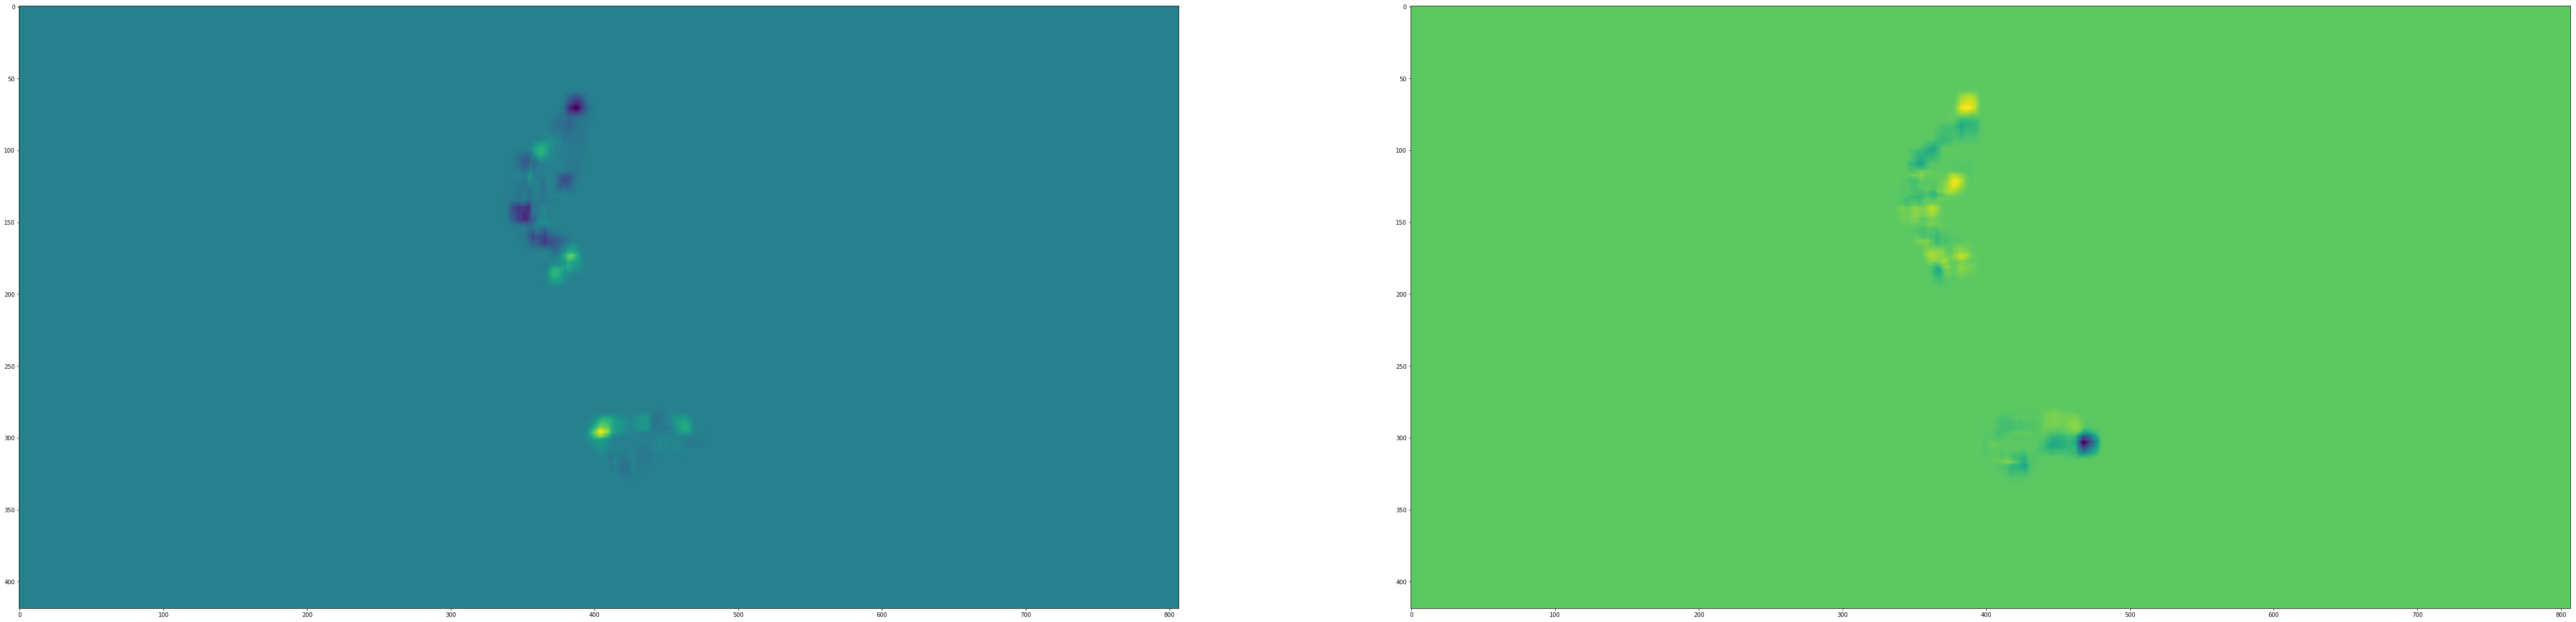

In [42]:
fig,ax = plt.subplots(1,2,figsize = (80,40))
ax[0].imshow(flow[:,:,0])
ax[1].imshow(flow[:,:,1])

### cv2.resize

In [287]:
res1 = cv2.resize(n[:,:,300],(419*32,31*60),interpolation = cv2.INTER_LINEAR)
res2 = cv2.resize(n[:,:,300],(419*32,31*60),interpolation = cv2.INTER_CUBIC)
res3 = cv2.resize(n[:,:,300],(419*32,31*60),interpolation = cv2.INTER_AREA)
res4 = cv2.resize(n[:,:,300],(419*32,31*60),interpolation = cv2.INTER_LANCZOS4)

In [288]:
n[:,:,300].shape

(31, 419)

In [289]:
res.shape

(1860, 13408)

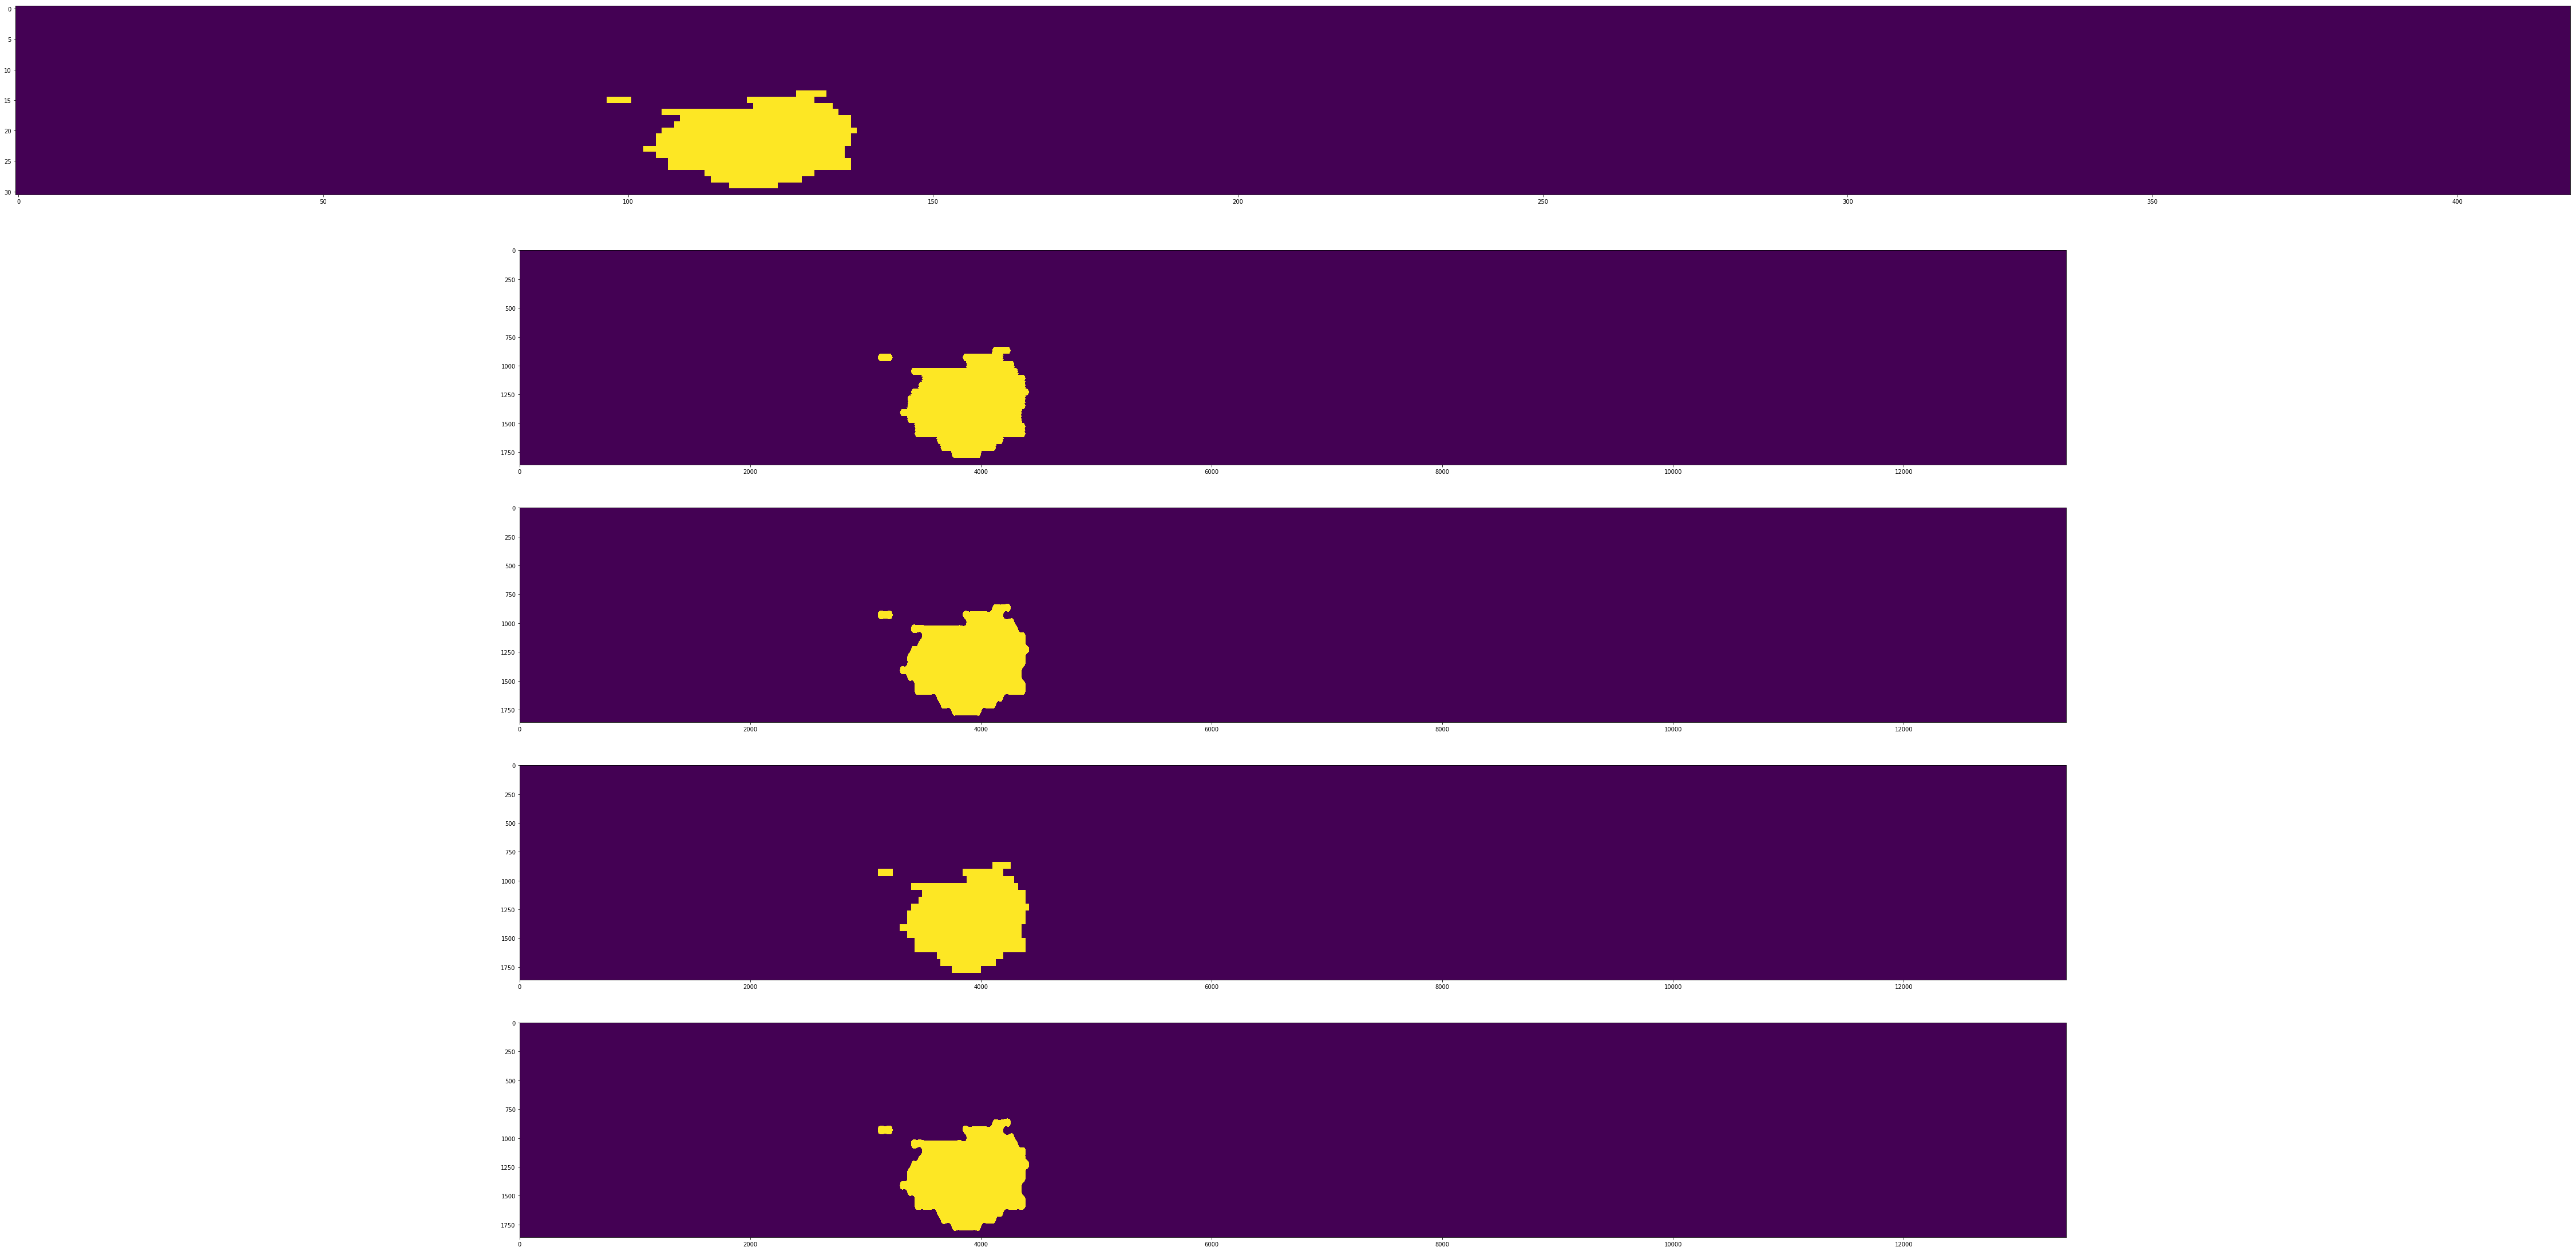

In [290]:
fig,ax = plt.subplots(5,1,figsize = (80,40))
ax[0].imshow(n[:,:,300])
ax[1].imshow(res1)
ax[2].imshow(res2)
ax[3].imshow(res3)
ax[4].imshow(res4)

In [60]:
np.unique(res)

array([0, 1], dtype=uint8)

In [93]:
m = np.zeros((62,419,807),dtype = 'uint8')

In [94]:
for i in range(807):
    res = cv2.resize(n[:,:,i],(419,62),interpolation = cv2.INTER_LINEAR)
    m[:,:,i]=res

# caliber measure

In [168]:
point = np.array([50,120,300])

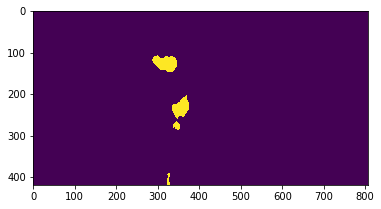

In [335]:
plt.imshow(m[50,:,:])

In [336]:
m[50,170,300]

0

In [304]:
from tqdm import tqdm_notebook as tqdm
from numba import jit

In [350]:
def min_distance(imgVolume,point,degree,accuracy):
    #heatmap = np.zeros((36,36))
    vector = np.array([0,0,0])
    min_dis = 99999
    counts = int(360/degree)
    for i in tqdm(range(counts)):
        for j in range(counts):
            a = (i-counts/2)/(counts/2)*math.pi
            b = (j-counts/2)/(counts/2)*math.pi
            z = math.sin(a)
            x = math.cos(a)*math.cos(b)
            y = math.cos(a)*math.sin(b)
            vec = np.array([z,x,y])
            dis = distance(imgVolume,point,vec,accuracy)
            #print (dis,vec)
            #heatmap[i,j]=dis
            if dis < min_dis:
                min_dis = dis
                vector = vec
    return vector#,heatmap

In [351]:
def distance(imgVolume,point,vector,accuracy):
    dis = 0
    begin = 0
    end = 990
    for i in range(100):
        d = i*10.0
        newpoint = point + d*vector
        try:
            if imgVolume[math.floor(newpoint[0]),math.floor(newpoint[1]),math.floor(newpoint[2])] == 1:
                begin = d
                end = d
            else:
                end = d
                break
        except:
            break
    #print (begin,end)
    for i in range(math.floor(math.log(10/accuracy,2)+1)):
        dmed2 = (begin + end)/2.0
        dmed1 = dmed2-accuracy
        med2 = point + dmed2 * vector
        med1 = point + dmed1 * vector
        if imgVolume[math.floor(med2[0]),math.floor(med2[1]),math.floor(med2[2])] == 0:
            if imgVolume[math.floor(med1[0]),math.floor(med1[1]),math.floor(med1[2])] == 1:
                dis = dmed2
                break
            else:
                end = dmed2
        else:
            begin = dmed2
        if i == math.floor(math.log(10/accuracy,2)+1)-1:
            dis = dmed2
    return dis

In [366]:
def calDiameter(imgVolume,point,vector,accuracy):
    dis1 = distance(imgVolume,point,vector,accuracy)
    dis2 = distance(imgVolume,point,-1*vector,accuracy)
    print (dis1,dis2)
    return dis1,dis2,dis1+dis2

In [353]:
distance(m,point,np.array([-1.2246468e-16, 1.0000000e+00, 1.2246468e-16]),0.01)

17.001953125

In [354]:
vector=min_distance(m,point,1,0.01)

In [359]:
vector

array([ 0.94551858, -0.07876207, -0.31589739])

In [360]:
np.max(dis)

77.7

In [361]:
diameter = cal_diameter(m,point,vector,0.01)

6.34765625 15.830078125


In [362]:
diameter

22.177734375

In [369]:
minDis = calDiameter(m,point,vector,0.01)[0]
reverseMinDis = calDiameter(m,point,vector,0.01)[1]
centerPoint = point + ((minDis-reverseMinDis)/2)*vector

6.34765625 15.830078125
6.34765625 15.830078125


In [370]:
print(centerPoint)

[ 45.51709699 120.37342756 301.49773616]


In [375]:
firstAxis = minDistance(m,centerPoint,1,0.01)
diameter1 = calDiameter(m,centerPoint,firstAxis,0.01)
    
    #find the second axis, passing the centerPoint, orthogonal to the first axis 
secondAxis = findSecondAxis(m,centerPoint,1,0.01,firstAxis)

8.30078125 10.0


NameError: name 'findSecondAxis' is not defined

In [403]:
secondAxis = findSecondAxis(m,centerPoint,1,0.01,firstAxis)

0
0
0
0
0
0
1
1
1
1
1
1
2
2
2
2
3
3
3
3
4
4
4
4
5
5
5
5
5
5
6
6
6
6
6
6
7
7
7
7
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
156
157
157
157
157
157
157
157
157
157
157
157
157
158
158
158
158
158
158
158
158
158
158
159
159
159
159
159
159
159
159
160
160
160
160
160
160
160
160
161
161
161
161
161
161
161
161
162
162
162
162
162
162
163
163
163
163
163
163
164
164
164
164
164
164
165
165
165
165
165
165
166
166
166
166
166
166
1

In [404]:
secondAxis

array([ 0.42261826, -0.68399917,  0.59459141])

In [406]:
diameter2 = calDiameter(m,point,secondAxis,0.01)

11.69921875 16.083984375


In [407]:
diameter2[2]

27.783203125

In [405]:
firstAxis.dot(secondAxis)

-0.0020982358059794537

In [400]:
math.sin(0.5/180*math.pi)

0.008726535498373935

In [374]:
def minDistance(imgVolume,point,degreeAccuracy,distanceAccuracy):
    '''
    get the direction with minimum distance between the axon boundry at this direction and the preset point
    
    input:
        imgVolume: [3D array] interpolatedAxon.
        point: [1*3 array] the point passing which we want a cross section and its diameter. 
        degreeAcuracy: [int] degree accuracy of the direction with minimum distance.
        distanceAccuracy: [int] accuracy when calculating the distance between the axon boundry and the point.
    output:
        vector: [1*3 array] the direction with minimum diatance, representing by a unit vector.
    '''

    vector = np.array([0,0,0])
    min_dis = 99999
    counts = int(360/degreeAccuracy)
    for i in tqdm(range(counts)):
        for j in range(counts):
            a = (i-counts/2)/(counts/2)*math.pi
            b = (j-counts/2)/(counts/2)*math.pi
            z = math.sin(a)
            x = math.cos(a)*math.cos(b)
            y = math.cos(a)*math.sin(b)
            vec = np.array([z,x,y])
            dis = distance(imgVolume,point,vec,distanceAccuracy)
            if dis < min_dis:
                min_dis = dis
                vector = vec
    return vector

In [ ]:
def diameter(segmentationVolume,mipLevel,axonId,point,degreeAccuracy,distanceAccuracy):
    '''
    calculate the diameter of an axon at a given point
    
    input:
        segmentationVolume: [3D array] the original segmentation image volume
        axonIdd: [int] the Id of desired axon.
        point: [1*3 array] the point (z,x,y) passing which we want a cross section and its diameter. 
        mipLevel: [int] the mipLevel of original segmentation image.
        degreeAcuracy: [int] degree accuracy of the diameter.
        distanceAccuracy: [int] accuracy of the length of the diameter.
    output:
        diameter1: [int] the diameter on the first axis of this axon at this point
        diameter2: [int] the diameter on the second axis of this axon at this point
    '''
        
    axon = preprocessing(segmentationVolume,axonId,mipLevel)
    
    #find the minimum distance
    vector = minDistance(axon,point,degreeAccuracy,distanceAccuracy)
    
    #redifine the centerPoint, this time closer to the center
    minDis = calDiameter(axon,point,vector,distanceAccuracy)[0]
    reverseMinDis = calDiameter(axon,point,vector,distanceAccuracy)[1]
    centerPoint = point + ((minDis-reverseMinDis)/2)*vector
    
    #find the first axis defined by the minimum distance passing the centerPoint
    firstAxis = minDistance(axon,centerPoint,degreeAccuracy,distanceAccuracy)
    diameter1 = calDiameter(axon,centerPoint,firstAxis,distanceAccuracy)
    
    #find the second axis, passing the centerPoint, orthogonal to the first axis 
    secondAxis = findSecondAxis(axon,centerPoint,degreeAccuracy,distanceAccuracy,firstAxis)
    diameter2 = calDiameter(axon,centerPoint,secondAxis,distanceAccuracy)

    return diameter1,diameter2,(diameter1+diameter2)/2

In [401]:
def findSecondAxis(imgVolume,point,degreeAccuracy,distanceAccuracy,firstAxis):
    '''
    get the direction with minimum distance between the axon boundry at this direction and the preset point
    
    input:
        imgVolume: [3D array] interpolatedAxon.
        point: [1*3 array] the point passing which we want a cross section and its diameter. 
        degreeAcuracy: [int] degree accuracy of the direction with minimum distance.
        distanceAccuracy: [int] accuracy when calculating the distance between the axon boundry and the point.
        firstAxis:[1*3 array] the vector which the secondAxis should be orthogonal to.
    output:
        secondAxis: [1*3 array] the direction of the secondAxis, with minimum diatance among all direction orthogonal 
                            to the firstAxis, representing by a unit vector.                  
    '''

    vector = np.array([0,0,0])
    min_dis = 99999
    counts = int(360/degreeAccuracy)
    for i in tqdm(range(counts)):
        for j in range(counts):
            a = (i-counts/2)/(counts/2)*math.pi
            b = (j-counts/2)/(counts/2)*math.pi
            z = math.sin(a)
            x = math.cos(a)*math.cos(b)
            y = math.cos(a)*math.sin(b)
            vec = np.array([z,x,y])
            if np.abs(vec.dot(firstAxis)) > 0.0088 :
                continue
            dis = distance(imgVolume,point,vec,distanceAccuracy)
            if dis < min_dis:
                min_dis = dis
                vector = vec
    return vector

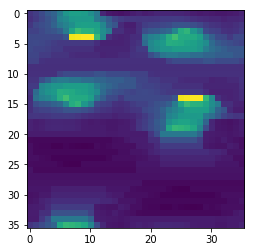

In [291]:
plt.imshow(heatmap)

### Visualization of the direction

In [210]:
dis = heatmap.reshape(1296)
colors = cm.hsv(dis/max(dis))
z = np.zeros((36,36))
x = np.zeros((36,36))
y = np.zeros((36,36))
for i in range(36):
    for j in range(36):
        a = (i-18)/18*math.pi
        b = (j-18)/18*math.pi
        z[i,j] = math.sin(a)
        x[i,j] = math.cos(a)*math.cos(b)
        y[i,j] = math.cos(a)*math.sin(b)
z.reshape(1296)
x.reshape(1296)
y.reshape(1296)

array([ 1.22464680e-16,  1.73648178e-01,  3.42020143e-01, ...,
       -4.92403877e-01, -3.36824089e-01, -1.71010072e-01])

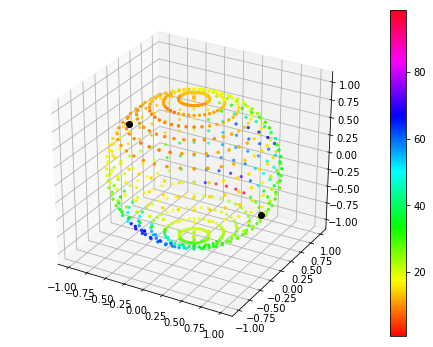

In [274]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')
colmap = cm.ScalarMappable(cmap=cm.hsv)
colmap.set_array(randrange(n, 0, 100))
yg = ax.scatter(x,y,z,c=cm.hsv(dis/max(dis)), marker='.')
cb = fig.colorbar(colmap)
ax.plot([vector[0],-1*vector[0]],[vector[1],-1*vector[1]],[vector[2],-1*vector[2]], "ko")